<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/04_DefineFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Install the Hijri converter package (if not installed)

In [ ]:
!pip install hijri-converter

In [2]:
import pandas as pd
import glob
import numpy as np
from hijri_converter import Hijri, Gregorian
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

**Read the data files**


*   Define correct seperator, tab in our example
*   Use dtype to enforce data type mainy in casefield field has mix data types
*   Use low_memory=False so you do not mind whatever type the undefined fields are read in they have mix data





In [3]:
pathData = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"
pathExternal = "/content/drive/MyDrive/ColabNotebooks/dataset/03_ExternalData/"
path = "/content/drive/MyDrive/ColabNotebooks/dataset/05_TrainedModel/"

In [4]:
with open(path + 'data.pk', 'rb') as f:
  df = pickle.load(f)
print("number of records:", len(df))

number of records: 6036393


In [ ]:
#df = df.reset_index()

In [5]:
df['DATE1'] = pd.to_datetime(df['DATE1'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df = df.sort_values('DATE1')

In [7]:
import hashlib

def hashSKU(s):  
      return int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)

In [8]:
df['hashedSKU'] = df['ITEM_ID'].apply(lambda s: hashSKU(s))

In [9]:
df = df.drop(columns=['ITEM_ID', 'TTL_VAL', 'TTL_CST'])

In [10]:
df

,SLS_CNTR_ID,DATE1,QTY,hashedSKU
47888,2,2019-01-01,11.0,47218709
512800,18,2019-01-01,2.0,77493065
1398112,20,2019-01-01,1.0,88590552
174746,34,2019-01-01,1.0,86379467
98241,18,2019-01-01,3.0,16425229
...,...,...,...,...
335414,57,2022-07-23,-3.0,57563719
143992,16,2022-07-23,32.0,99792892
434216,16,2022-07-23,8.0,15502483
520011,16,2022-07-23,5.0,68431414


Test some data to ensure everything is read correctly

**Feature Creation**

In [11]:
from hijri_converter import Hijri, Gregorian

def hijriDate(row):  
    y = row['DATE1'].year
    m = row['DATE1'].month
    d = row['DATE1'].day
    return Gregorian(y, m, d).to_hijri()

def isRamadan(dt):  
    if dt.month == 9:
      return 1
    else:
      return 0

def isRamadanEnd(dt):  
    if dt.month == 9 and dt.day >= 21:
      return 1
    else:
      return 0

def isEid(dt):  
    if (dt.month == 10 and dt.day < 4) or (dt.month == 12 and dt.day < 9 and dt.day > 14):
      return 1
    else:
      return 0

In [12]:
def isWeekend(dt):  
    if dt.weekday() == 4 or dt.weekday() == 5: # Monday is 0
      return 1
    else:
      return 0

def isSalaryweek(dt):  
    if dt.day >= 25:
      return 1
    else:
      return 0

def isNationalday(dt):  
    if (dt.month == 2 and dt.day == 22) or (dt.month == 9 and dt.day == 23) :
      return 1
    else:
      return 0

Convert DATE1 from string to date format

**Date static features, convert date to features**

If DATE1 is indexed then use the below instead of the above

In [13]:
df['dayofyear'] = df['DATE1'].apply(lambda dt: dt.dayofyear)
df['Monthday'] = df['DATE1'].apply(lambda dt: dt.day)
df['Weekday'] = df['DATE1'].apply(lambda dt: dt.dayofweek)
df['weekofyear'] = df['DATE1'].apply(lambda dt: dt.week)
df['month'] = df['DATE1'].apply(lambda dt: dt.month)
df['quarter'] = df['DATE1'].apply(lambda dt: dt.quarter)

df['isSalaryweek'] = df['DATE1'].apply(lambda dt: isSalaryweek(dt))
df['isWeekend'] = df['DATE1'].apply(lambda dt: isWeekend(dt))
df['isNationalday'] = df['DATE1'].apply(lambda dt: isNationalday(dt))

df['hijri'] = df.apply(lambda row: hijriDate(row), axis=1)
df['isRamadan'] = df['hijri'].apply(lambda dt: isRamadan(dt))
df['isRamadanEnd'] = df['hijri'].apply(lambda dt: isRamadanEnd(dt))
df['isEid'] = df['hijri'].apply(lambda dt: isEid(dt))

df = df.drop(columns=['hijri'])
df

,SLS_CNTR_ID,DATE1,QTY,hashedSKU,dayofyear,Monthday,Weekday,weekofyear,month,quarter,isSalaryweek,isWeekend,isNationalday,isRamadan,isRamadanEnd,isEid
47888,2,2019-01-01,11.0,47218709,1,1,1,1,1,1,0,0,0,0,0,0
512800,18,2019-01-01,2.0,77493065,1,1,1,1,1,1,0,0,0,0,0,0
1398112,20,2019-01-01,1.0,88590552,1,1,1,1,1,1,0,0,0,0,0,0
174746,34,2019-01-01,1.0,86379467,1,1,1,1,1,1,0,0,0,0,0,0
98241,18,2019-01-01,3.0,16425229,1,1,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335414,57,2022-07-23,-3.0,57563719,204,23,5,29,7,3,0,1,0,0,0,0
143992,16,2022-07-23,32.0,99792892,204,23,5,29,7,3,0,1,0,0,0,0
434216,16,2022-07-23,8.0,15502483,204,23,5,29,7,3,0,1,0,0,0,0
520011,16,2022-07-23,5.0,68431414,204,23,5,29,7,3,0,1,0,0,0,0


In [14]:
dfx = df

Import school days and calendar related activities that could impact all items and sales centers and add them to the features dataframe

In [15]:
calenderFeatures = pd.read_csv(pathExternal +'calenderFeatures.csv', sep=',', lineterminator='\r', low_memory=False)
calenderFeatures = calenderFeatures.replace('\n','', regex=True)
calenderFeatures['DATE1'] = pd.to_datetime(calenderFeatures['DATE1'], format='%Y-%m-%d %H:%M:%S')
df = pd.merge(df, 
              calenderFeatures, 
              on =['DATE1'], 
              how ='inner')
df

In [44]:
Categories = pd.read_csv(pathExternal +'Categories.csv', sep=',', lineterminator='\r', low_memory=False)
print(Categories)
Categories = Categories.replace('\n','', regex=True)
Categories = Categories.dropna(subset=['CL_1']) 
Categories[['CL_1']] = Categories[['CL_1']] #.astype(int, errors = 'raise')
Categories = Categories[['CL_1','Category']]
Categories = Categories.reset_index()
Categories = Categories.drop(columns=['index'])
Categories = Categories.dropna(subset=['Category']) 
print(Categories.dtypes)
Categories

    CL_1         Category
0      1            Local
1      2         Imported
2      3         HomeMade
3      4      RawMaterial
4      5            Brand
5      6    SisterCompany
6      7          Partner
7      8        Packaging
8      9        Cancelled
9     10       Itproducts
10    11           Brand2
11    12  HomeMadewithVAT
CL_1         int64
Category    object
dtype: object


,CL_1,Category
0,1,Local
1,2,Imported
2,3,HomeMade
3,4,RawMaterial
4,5,Brand
5,6,SisterCompany
6,7,Partner
7,8,Packaging
8,9,Cancelled
9,10,Itproducts


Add SKU category

Read and clean categories file

In [45]:
SKUcategory = pd.read_csv(pathExternal +'ITEMS_MASTER.csv', sep='\t', lineterminator='\r', low_memory=False)
SKUcategory = SKUcategory.replace('\n','', regex=True)
SKUcategory[['ITEM_ID']] = SKUcategory[['ITEM_ID']].astype(str, errors = 'raise')
SKUcategory = SKUcategory.dropna(subset=['CL_1']) 
SKUcategory[['CL_1']] = SKUcategory[['CL_1']].astype(int, errors = 'raise')
SKUcategory = SKUcategory.reset_index()
SKUcategory = SKUcategory.drop(columns=['index'])
SKUcategory = SKUcategory[['ITEM_ID','CL_1']]
print(SKUcategory.dtypes)
SKUcategory

ITEM_ID    object
CL_1        int64
dtype: object


,ITEM_ID,CL_1
0,124913,3
1,127745,3
2,127747,3
3,127765,3
4,12785,3
...,...,...
10075,60501445,3
10076,60501446,3
10077,60501456,3
10078,60501457,3


In [46]:
SKUcategory = pd.merge(SKUcategory, 
              Categories, 
              on =['CL_1'], 
              how ='inner')
SKUcategory['hashedSKU'] = SKUcategory['ITEM_ID'].apply(lambda s: hashSKU(s))
SKUcategory = SKUcategory[['hashedSKU','Category']]
SKUcategory

,hashedSKU,Category
0,776028,HomeMade
1,48883916,HomeMade
2,88493166,HomeMade
3,3142075,HomeMade
4,38301513,HomeMade
...,...,...
10075,57303538,Packaging
10076,45381365,Packaging
10077,50033708,Packaging
10078,89931447,Brand2


In [47]:
oneHot = (pd.get_dummies(SKUcategory.Category, prefix='Category').reset_index())
SKUcategory = SKUcategory.join(oneHot)
SKUcategory = SKUcategory.drop(columns=['Category', 'index'])
SKUcategory

,hashedSKU,Category_Brand,Category_Brand2,Category_Cancelled,Category_HomeMade,Category_HomeMadewithVAT,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany
0,776028,0,0,0,1,0,0,0,0,0,0,0,0
1,48883916,0,0,0,1,0,0,0,0,0,0,0,0
2,88493166,0,0,0,1,0,0,0,0,0,0,0,0
3,3142075,0,0,0,1,0,0,0,0,0,0,0,0
4,38301513,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,57303538,0,0,0,0,0,0,0,0,1,0,0,0
10076,45381365,0,0,0,0,0,0,0,0,1,0,0,0
10077,50033708,0,0,0,0,0,0,0,0,1,0,0,0
10078,89931447,0,1,0,0,0,0,0,0,0,0,0,0


In [48]:
df = pd.merge(df, 
              SKUcategory, 
              on =['hashedSKU'], 
              how ='inner')

In [49]:
df = df.set_index('DATE1')

In [50]:
df

,SLS_CNTR_ID,QTY,hashedSKU,dayofyear,Monthday,Weekday,weekofyear,month,quarter,isSalaryweek,...,Category_Cancelled,Category_HomeMade,Category_HomeMadewithVAT,Category_Imported,Category_Itproducts,Category_Local,Category_Packaging,Category_Partner,Category_RawMaterial,Category_SisterCompany
DATE1,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2,11.0,47218709,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2019-01-01,24,1.0,47218709,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2019-01-01,20,6.0,47218709,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2019-01-01,26,60.0,47218709,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2019-01-01,31,2.0,47218709,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-21,59,14.0,9032316,202,21,3,29,7,3,0,...,0,0,0,0,0,0,0,0,1,0
2022-07-22,19,1.0,9032316,203,22,4,29,7,3,0,...,0,0,0,0,0,0,0,0,1,0
2022-07-21,59,11.0,43170587,202,21,3,29,7,3,0,...,0,0,0,0,0,0,0,0,1,0


In [51]:
FEATURES = list(df.columns.values)
print('number of features:', len(FEATURES))
FEATURES

number of features: 29


['SLS_CNTR_ID',
 'QTY',
 'hashedSKU',
 'dayofyear',
 'Monthday',
 'Weekday',
 'weekofyear',
 'month',
 'quarter',
 'isSalaryweek',
 'isWeekend',
 'isNationalday',
 'isRamadan',
 'isRamadanEnd',
 'isEid',
 'Holiday',
 'AcademicCalendarSemester',
 'Category_Brand',
 'Category_Brand2',
 'Category_Cancelled',
 'Category_HomeMade',
 'Category_HomeMadewithVAT',
 'Category_Imported',
 'Category_Itproducts',
 'Category_Local',
 'Category_Packaging',
 'Category_Partner',
 'Category_RawMaterial',
 'Category_SisterCompany']

As all field should be either numerical or boolean and string is not accepted, we are running the model for one SKU only, filtering the dataframe where ITEM_ID is matching with the SKU code, and drop all others

In [52]:
with open(path + 'modelData.pk', 'wb') as f:
  pickle.dump(df, f)

In [53]:
df124766 = df.query(f'hashedSKU == {hashSKU("124766")}')

In [54]:
with open(path + '124766Data.pk', 'wb') as f:
  pickle.dump(df124766, f)

**Below to be implemented in the future**

Import selective days and calendar related activities that could impact selective items and sales centers and add them to the features dataframe

In [ ]:
df.set_index("DATE1", inplace = True)

**Visualize our Feature / Target Relationship**

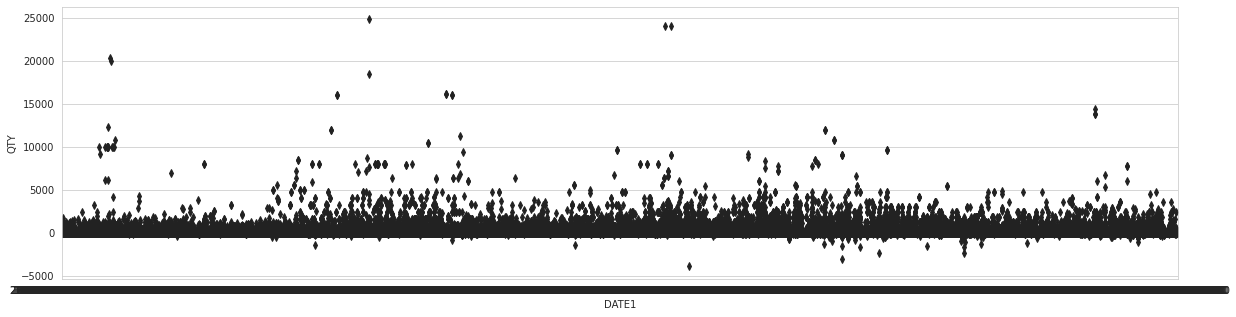

In [55]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [20, 5] #  [width, height]  
sns.boxplot(x = df.index.get_level_values('DATE1'),  # ('SLS_CNTR_ID')
            y = 'QTY',
            data = df, palette="Blues", width=0.3)